In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/train_tfidf_features.csv')



In [3]:

#split training df to train set and test set , 8:2 split

train_df = df.iloc[:int(len(df)*0.8), :]
test_df = df.iloc[int(len(df)*0.8):, :]

X_train, y_train = train_df.drop(columns=["id","label"]),train_df["label"]
X_test, y_test = test_df.drop(columns=["id","label"]),test_df["label"]


counts = train_df["label"].value_counts()
print(counts)



label
0    8507
1    5240
Name: count, dtype: int64


In [ ]:

# Create a class obj of Logistic Regression for used in Task 3

class LogisticRegression:
    def __init__(self,seed=0,learning_rate = 0.01,batch_size = 100, epochs = 20,random_state = 0):
        # X --> training data feaatures.
        # y --> training data lable.   
        # bs --> Batch Size.
        # epochs --> Number of iterations.
        # lr --> Learning rate. 
        # size-> number of training examples
        # features-> number of features 
        self.size,self.features = 0,0
        self.y_hat = 0.0
        self.bs  = batch_size
        self.lr = learning_rate
        self.epochs =epochs
        self.class_weights = None 
        self.random = random_state
        
        self.loss = 0

    def sigmoid(self,z):
        return 1.0/(1 + np.exp(-z))
    
    def loss_log(self,y,y_hat,sample_weights):
        #included class weights
        if self.class_weights is  None:
            
            sample_weights = np.ones_like(y)
        else:
            sample_weights = np.vectorize(self.class_weights.get)(y.ravel()).reshape(-1, 1)
        base_LOSS =  -np.mean(sample_weights *  (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
        l1_penalty = self.Lambda * np.sum(np.abs(self.weights)) 
        return base_LOSS + l1_penalty
    
    def gradients(self,X, y, y_hat,sample_weights):
        #included class weights
        m = X.shape[0]
        if self.class_weights is  None:
            
            sample_weights = np.ones_like(y)
        else:
            sample_weights = np.vectorize(self.class_weights.get)(y.ravel()).reshape(-1, 1)
        dw = 1/m * np.dot(X.T, sample_weights*(y_hat - y))+ self.Lambda * np.sign(self.weights) # dw + L1 regularization 
        db = np.mean(sample_weights*(y_hat - y))

        return dw, db   
    
    def train(self,X,y,Lambda=1,class_weights=None,):
        data = pd.concat([X, y], axis=1).sample(frac=1, random_state=self.random).reset_index(drop=True)
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
        #Hyperparameter: 
        #Lambda --> L1 regularization 
        #class_weights --> sample weights
        
        self.Lambda = Lambda
        self.class_weights = class_weights
        #Added class weights to offset data class bias
        if self.class_weights is  None:
            
            sample_weights = np.ones_like(y)
        else:
            sample_weights = np.vectorize(self.class_weights.get)(y.ravel()).reshape(-1, 1)
            
        self.size,features =X.shape
        #Randomize initials bias and weights
        self.weights = np.zeros((features, 1))
        self.bias  =0
        # Reshaping y.
       
        y = y.values.reshape(self.size, 1)
        # Training loop.
        for epoch in range(self.epochs):
            for i in range((self.size-1)//self.bs + 1):
                # Defining batches. SGD.
                start_i = i*self.bs
                end_i = start_i + self.bs
                xb = X[start_i:end_i]
                yb = y[start_i:end_i]
                batch_weights = sample_weights[start_i:end_i]  
                # Calculating hypothesis/prediction.
                self.y_hat = self.sigmoid(np.dot(xb, self.weights) + self.bias)
                #print("Probs:", self.y_hat[:20])
            
                dw, db = self.gradients(xb, yb, self.y_hat, batch_weights)

                # Updating the parameters.
                self.weights -= self.lr*dw
                self.bias -= self.lr*db

            # Calculating/update loss log
            self.loss =self.loss_log(y, self.sigmoid(np.dot(X, self.weights) + self.bias), sample_weights)

           

        # returning weights, bias and losses(List).

        return self.weights, self.bias, self.loss
    
    def predict_proba(self,X):
        #input X must be iterable 
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        ans = (probs >= threshold).astype(int)
        return ans
    

lg = LogisticRegression(batch_size=1000, learning_rate=0.1, epochs=80)

lg.train(X_train,y_train,class_weights={1:2.6,0:1.6})



C:\Users\Wei Yang\AppData\Local\Temp\ipykernel_27068\3392417389.py:64: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sample_weights = np.vectorize(self.class_weights.get)(y.ravel()).reshape(-1, 1)


In [88]:
from sklearn import metrics 

# Convert probabilities to class labels using the threshold

print(metrics.classification_report(y_test, lg.predict(X_test)))



              precision    recall  f1-score   support

           0       0.62      1.00      0.76      2126
           1       0.11      0.00      0.00      1311

    accuracy                           0.62      3437
   macro avg       0.36      0.50      0.38      3437
weighted avg       0.42      0.62      0.47      3437



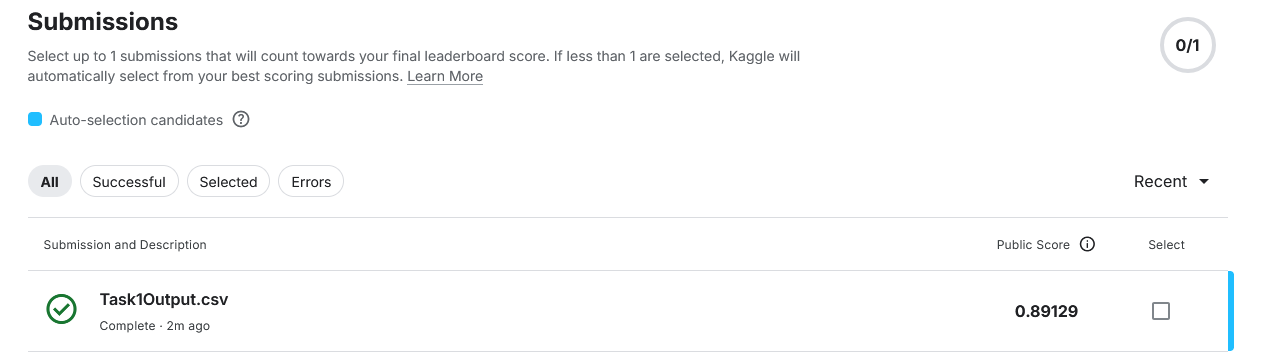

## threshold testing


In [86]:
probs = lg.predict_proba(X_test)


threshold = 0.5

# Convert probabilities to class labels using the threshold
ans = (probs >= threshold).astype(int)

print(metrics.classification_report(y_test, ans))


              precision    recall  f1-score   support

           0       0.59      0.85      0.70      2126
           1       0.15      0.04      0.07      1311

    accuracy                           0.54      3437
   macro avg       0.37      0.45      0.38      3437
weighted avg       0.42      0.54      0.46      3437



## Write to CSV

In [81]:
test_df = pd.read_csv('data/test_tfidf_features.csv')
test_data,id = test_df.drop(columns=["id"]),test_df["id"]
probs = lg.predict(test_data)
ans = (probs >= 0.4).astype(int)


final=id.to_frame()    
print(final.shape)
final["label"] = ans
final = final.rename(columns={"id":"row ID"})
final.to_csv('Task1Output.csv',index=False )

(4296, 1)
